In [13]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [14]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(), # converts to float AND divides by 255 (normalize).
    transforms.Normalize(mean=[0.5], std=[0.5])  # scale to [-1, 1]
])

# Load Fashion-MNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(root="C:\\Abhishek_Data\\Datasets", train=True, transform=transform)
train_loader  = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)

test_dataset = torchvision.datasets.FashionMNIST(root='C:\\Abhishek_Data\\Datasets', train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

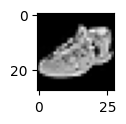

In [15]:
# get images and labels from loader
numbers, labels = next(iter(train_loader))

# visualize one image
images = numbers.numpy()
# get one image from the batch
img = np.squeeze(images[0])
fig = plt.figure(figsize = (1,1)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


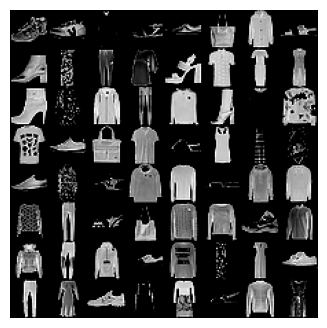

In [16]:
#visualize a batch of images
grid = torchvision.utils.make_grid(numbers, nrow=8, padding=0, scale_each=True)
fig = plt.figure(figsize=(16,4))
plt.imshow(grid.cpu().permute(1,2,0))
plt.axis('off')
plt.show()

Define the Model:  A GAN is comprised of two adversarial networks, a discriminator and a generator.

Discriminator : The discriminator network is going to be a pretty typical linear classifier. To make this network a universal function approximator, we'll need at least one hidden layer, and these hidden layers should have a Leaky ReLu activation function applied to their outputs

In [17]:
class Discriminator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator, self).__init__()

        self.disciminator = nn.Sequential(
            nn.Linear(input_size, hidden_dim*4),
            nn.ReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim*4, hidden_dim*2),
            nn.ReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim*2, hidden_dim),
            nn.ReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, output_size),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        # flatten image
        out = self.disciminator(x)

        return out

Generator : The generator network will be almost exactly the same as the discriminator network, except that we're applying a tanh activation function to our output layer. Tanh scales the output to be between -1 and 1, instead of 0 and 1. these outputs to be comparable to the real input pixel values, which are read in as normalized values between 0 and 1.

In [18]:
class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()

        self.generator = nn.Sequential(
            nn.Linear(input_size, hidden_dim),
            nn.ReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim*2),
            nn.ReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim*2, hidden_dim*4),
            nn.ReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim*4, output_size),
            nn.Tanh()
        )
        
    def forward(self, x):
        out = self.generator(x)
        return out

In [19]:
# Discriminator hyperparams
input_size    = 784   # Size of input image to discriminator (28*28)
d_hidden_size = 32    # Size of last hidden layer in the discriminator
d_output_size = 1     # Size of discriminator output (real or fake)

# Generator hyperparams
z_size        = 100  # Size of latent vector to give to generator
g_hidden_size = 32   # Size of first hidden layer in the generator
g_output_size = 784  # Size of discriminator output (generated image)

In [20]:
# build models and move to device
D = Discriminator(input_size, d_hidden_size, d_output_size)
G = Generator(z_size, g_hidden_size, g_output_size)

# Send models to device
D = D.to(device)
G = G.to(device)

In [21]:
# Loss and optimizers
criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr=0.0001)
g_optimizer = optim.Adam(G.parameters(), lr=0.0001)

In [22]:
# For generating latent noise
def generate_noise(batch_size, latent_size):
    return torch.randn(batch_size, latent_size, device=device)

Epoch [1/150], d_loss: 0.4419, g_loss: 2.4049
Epoch [2/150], d_loss: 0.3572, g_loss: 4.5063
Epoch [3/150], d_loss: 0.4328, g_loss: 4.5803
Epoch [4/150], d_loss: 0.4212, g_loss: 4.1018
Epoch [5/150], d_loss: 0.6795, g_loss: 3.3534
Epoch [6/150], d_loss: 0.6522, g_loss: 3.4369
Epoch [7/150], d_loss: 0.6176, g_loss: 2.8692
Epoch [8/150], d_loss: 0.6040, g_loss: 3.0491
Epoch [9/150], d_loss: 0.6185, g_loss: 2.7386
Epoch [10/150], d_loss: 0.6938, g_loss: 2.8177
Epoch [11/150], d_loss: 0.8406, g_loss: 2.3372
Epoch [12/150], d_loss: 0.5800, g_loss: 2.3883
Epoch [13/150], d_loss: 0.8369, g_loss: 2.0502
Epoch [14/150], d_loss: 0.7747, g_loss: 1.8464
Epoch [15/150], d_loss: 0.8551, g_loss: 2.0163


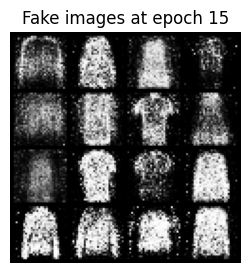

Epoch [16/150], d_loss: 0.8898, g_loss: 1.9419
Epoch [17/150], d_loss: 0.8417, g_loss: 1.6064
Epoch [18/150], d_loss: 0.9320, g_loss: 1.7942
Epoch [19/150], d_loss: 1.0444, g_loss: 1.5635
Epoch [20/150], d_loss: 1.0202, g_loss: 1.5391
Epoch [21/150], d_loss: 1.0590, g_loss: 1.5508
Epoch [22/150], d_loss: 1.0629, g_loss: 1.3729
Epoch [23/150], d_loss: 1.1081, g_loss: 1.5098
Epoch [24/150], d_loss: 0.9042, g_loss: 1.3914
Epoch [25/150], d_loss: 1.1178, g_loss: 1.2662
Epoch [26/150], d_loss: 1.1297, g_loss: 1.2789
Epoch [27/150], d_loss: 1.0381, g_loss: 1.3687
Epoch [28/150], d_loss: 1.1289, g_loss: 1.2616
Epoch [29/150], d_loss: 1.0082, g_loss: 1.3265
Epoch [30/150], d_loss: 1.0320, g_loss: 1.4104


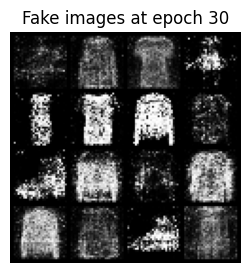

Epoch [31/150], d_loss: 1.1953, g_loss: 1.2456
Epoch [32/150], d_loss: 1.0089, g_loss: 1.1570
Epoch [33/150], d_loss: 1.0746, g_loss: 1.1452
Epoch [34/150], d_loss: 1.1094, g_loss: 1.2545
Epoch [35/150], d_loss: 1.1887, g_loss: 1.2378
Epoch [36/150], d_loss: 1.2147, g_loss: 1.1475
Epoch [37/150], d_loss: 1.1101, g_loss: 1.1621
Epoch [38/150], d_loss: 1.2498, g_loss: 1.2242
Epoch [39/150], d_loss: 1.0896, g_loss: 1.2550
Epoch [40/150], d_loss: 1.1959, g_loss: 1.2255
Epoch [41/150], d_loss: 1.1438, g_loss: 1.1712
Epoch [42/150], d_loss: 1.1904, g_loss: 1.0640
Epoch [43/150], d_loss: 1.2860, g_loss: 1.1674
Epoch [44/150], d_loss: 1.1899, g_loss: 1.1487
Epoch [45/150], d_loss: 1.1263, g_loss: 1.1342


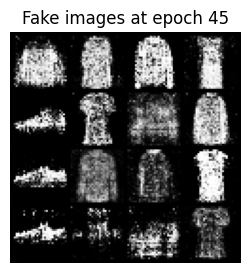

Epoch [46/150], d_loss: 1.0758, g_loss: 0.9601
Epoch [47/150], d_loss: 1.1714, g_loss: 1.0997
Epoch [48/150], d_loss: 1.0825, g_loss: 1.1307
Epoch [49/150], d_loss: 1.2205, g_loss: 1.1627
Epoch [50/150], d_loss: 1.1138, g_loss: 1.1061
Epoch [51/150], d_loss: 1.3098, g_loss: 1.1173
Epoch [52/150], d_loss: 1.1126, g_loss: 1.1456
Epoch [53/150], d_loss: 1.2215, g_loss: 1.0824
Epoch [54/150], d_loss: 1.3346, g_loss: 1.0339
Epoch [55/150], d_loss: 1.1578, g_loss: 1.0870
Epoch [56/150], d_loss: 1.2761, g_loss: 1.0708
Epoch [57/150], d_loss: 1.1015, g_loss: 0.9937
Epoch [58/150], d_loss: 1.1391, g_loss: 1.0518
Epoch [59/150], d_loss: 1.2619, g_loss: 1.0800
Epoch [60/150], d_loss: 1.4081, g_loss: 1.0550


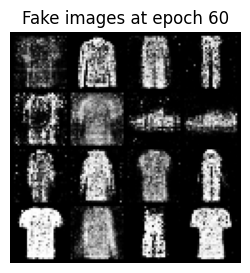

Epoch [61/150], d_loss: 1.2184, g_loss: 1.0739
Epoch [62/150], d_loss: 1.2182, g_loss: 1.0435
Epoch [63/150], d_loss: 1.1649, g_loss: 1.0301
Epoch [64/150], d_loss: 1.2068, g_loss: 0.9879
Epoch [65/150], d_loss: 1.2302, g_loss: 1.0636
Epoch [66/150], d_loss: 1.2185, g_loss: 1.0664
Epoch [67/150], d_loss: 1.2047, g_loss: 0.9638
Epoch [68/150], d_loss: 1.1664, g_loss: 0.9828
Epoch [69/150], d_loss: 1.1927, g_loss: 0.9706
Epoch [70/150], d_loss: 1.2686, g_loss: 1.0444
Epoch [71/150], d_loss: 1.1970, g_loss: 1.0108
Epoch [72/150], d_loss: 1.1574, g_loss: 1.0914
Epoch [73/150], d_loss: 1.1871, g_loss: 0.9727
Epoch [74/150], d_loss: 1.2293, g_loss: 0.9727
Epoch [75/150], d_loss: 1.3576, g_loss: 0.9630


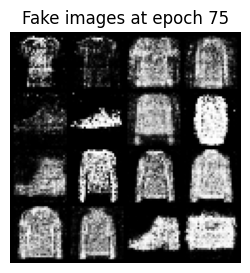

Epoch [76/150], d_loss: 1.3316, g_loss: 0.9709
Epoch [77/150], d_loss: 1.2073, g_loss: 1.0133
Epoch [78/150], d_loss: 1.2264, g_loss: 1.0479
Epoch [79/150], d_loss: 1.2116, g_loss: 0.9939
Epoch [80/150], d_loss: 1.2932, g_loss: 1.0503
Epoch [81/150], d_loss: 1.1563, g_loss: 1.0670
Epoch [82/150], d_loss: 1.1707, g_loss: 0.9665
Epoch [83/150], d_loss: 1.2164, g_loss: 0.9378
Epoch [84/150], d_loss: 1.3577, g_loss: 1.0000
Epoch [85/150], d_loss: 1.1953, g_loss: 0.9585
Epoch [86/150], d_loss: 1.2281, g_loss: 0.9256
Epoch [87/150], d_loss: 1.2923, g_loss: 0.9222
Epoch [88/150], d_loss: 1.2078, g_loss: 0.9990
Epoch [89/150], d_loss: 1.1923, g_loss: 0.9506
Epoch [90/150], d_loss: 1.1557, g_loss: 0.9715


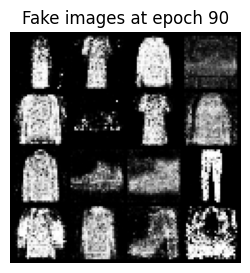

Epoch [91/150], d_loss: 1.2106, g_loss: 0.9928
Epoch [92/150], d_loss: 1.2555, g_loss: 0.9258
Epoch [93/150], d_loss: 1.2611, g_loss: 0.9677
Epoch [94/150], d_loss: 1.2218, g_loss: 0.9646
Epoch [95/150], d_loss: 1.1633, g_loss: 0.9565
Epoch [96/150], d_loss: 1.3374, g_loss: 0.9103
Epoch [97/150], d_loss: 1.1710, g_loss: 1.0247
Epoch [98/150], d_loss: 1.2457, g_loss: 0.9158
Epoch [99/150], d_loss: 1.3261, g_loss: 0.9922
Epoch [100/150], d_loss: 1.2377, g_loss: 0.9685
Epoch [101/150], d_loss: 1.2245, g_loss: 0.9840
Epoch [102/150], d_loss: 1.3084, g_loss: 0.9890
Epoch [103/150], d_loss: 1.2525, g_loss: 0.9147
Epoch [104/150], d_loss: 1.2442, g_loss: 0.9143
Epoch [105/150], d_loss: 1.2744, g_loss: 0.9950


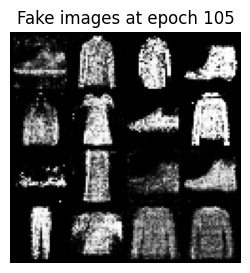

Epoch [106/150], d_loss: 1.3000, g_loss: 0.8627
Epoch [107/150], d_loss: 1.2598, g_loss: 0.8954
Epoch [108/150], d_loss: 1.2071, g_loss: 0.8925
Epoch [109/150], d_loss: 1.2800, g_loss: 0.9925
Epoch [110/150], d_loss: 1.2653, g_loss: 0.9814
Epoch [111/150], d_loss: 1.2016, g_loss: 0.8950
Epoch [112/150], d_loss: 1.2540, g_loss: 0.9737
Epoch [113/150], d_loss: 1.2417, g_loss: 0.8677
Epoch [114/150], d_loss: 1.2978, g_loss: 0.8955
Epoch [115/150], d_loss: 1.2997, g_loss: 0.9130
Epoch [116/150], d_loss: 1.3313, g_loss: 0.9205
Epoch [117/150], d_loss: 1.2254, g_loss: 0.9173
Epoch [118/150], d_loss: 1.2413, g_loss: 0.9208
Epoch [119/150], d_loss: 1.2373, g_loss: 0.9363
Epoch [120/150], d_loss: 1.2591, g_loss: 0.8686


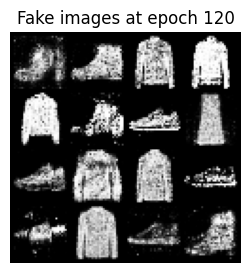

Epoch [121/150], d_loss: 1.2144, g_loss: 0.9137
Epoch [122/150], d_loss: 1.2504, g_loss: 0.9006
Epoch [123/150], d_loss: 1.3206, g_loss: 0.9338
Epoch [124/150], d_loss: 1.2518, g_loss: 0.9092
Epoch [125/150], d_loss: 1.3210, g_loss: 0.9072
Epoch [126/150], d_loss: 1.3206, g_loss: 0.9032
Epoch [127/150], d_loss: 1.3457, g_loss: 0.8912
Epoch [128/150], d_loss: 1.2387, g_loss: 0.8769
Epoch [129/150], d_loss: 1.3274, g_loss: 0.9619
Epoch [130/150], d_loss: 1.2898, g_loss: 0.9309
Epoch [131/150], d_loss: 1.2841, g_loss: 0.8912
Epoch [132/150], d_loss: 1.2630, g_loss: 0.9399
Epoch [133/150], d_loss: 1.2936, g_loss: 0.8848
Epoch [134/150], d_loss: 1.2580, g_loss: 0.8794
Epoch [135/150], d_loss: 1.2932, g_loss: 0.9334


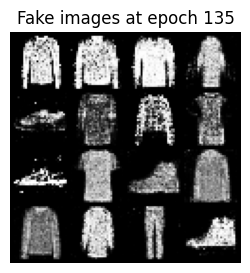

Epoch [136/150], d_loss: 1.2388, g_loss: 0.9554
Epoch [137/150], d_loss: 1.3325, g_loss: 0.8941
Epoch [138/150], d_loss: 1.2619, g_loss: 0.9099
Epoch [139/150], d_loss: 1.2640, g_loss: 0.8907
Epoch [140/150], d_loss: 1.2902, g_loss: 0.8838
Epoch [141/150], d_loss: 1.3640, g_loss: 0.8781
Epoch [142/150], d_loss: 1.2444, g_loss: 0.9620
Epoch [143/150], d_loss: 1.2858, g_loss: 0.8695
Epoch [144/150], d_loss: 1.3048, g_loss: 0.8712
Epoch [145/150], d_loss: 1.2968, g_loss: 0.8591
Epoch [146/150], d_loss: 1.2796, g_loss: 0.8651
Epoch [147/150], d_loss: 1.3520, g_loss: 0.9196
Epoch [148/150], d_loss: 1.2773, g_loss: 0.9063
Epoch [149/150], d_loss: 1.3052, g_loss: 0.9091
Epoch [150/150], d_loss: 1.3358, g_loss: 0.9093


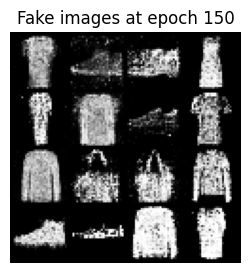

In [23]:
num_epochs = 150

# Training loop
for epoch in range(num_epochs):
    for real_images, _ in train_loader:
        real_images = real_images.view(-1, input_size).to(device)
        batch_size_curr = real_images.size(0)

        # Labels for real and fake images
        #real_labels = torch.ones(batch_size_curr, 1).to(device)
        real_labels = torch.full((batch_size_curr, 1), 0.9).to(device)
        fake_labels = torch.zeros(batch_size_curr, 1).to(device)

        # Train Discriminator
        outputs = D(real_images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs

        noise = generate_noise(batch_size_curr, z_size)
        fake_images = G(noise)
        outputs = D(fake_images.detach())
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs

        d_loss = d_loss_real + d_loss_fake

        D.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        noise = generate_noise(batch_size_curr, z_size)
        fake_images = G(noise)
        outputs = D(fake_images)
        g_loss = criterion(outputs, real_labels)  # We want the fake images to be classified as real

        G.zero_grad()
        g_loss.backward()
        g_optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}')

    # Generate and show fake images every 10 epochs
    if (epoch+1) % 15 == 0:
        with torch.no_grad():
            fake_images = fake_images.reshape(-1, 1, 28, 28)
            fake_images = fake_images[:16]
            grid = torchvision.utils.make_grid(fake_images, nrow=4, normalize=True)
            plt.figure(figsize=(3,3))
            plt.imshow(grid.permute(1,2,0).cpu())
            plt.axis('off')
            plt.title(f'Fake images at epoch {epoch+1}')
            plt.show()